In [1]:
import xarray as xr
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import json
import copy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import matplotlib.colors as mcolors

import climate_train
import climate_data
import climate_models

In [2]:
def longitude_average(R2):
    mr2=np.zeros(R2.shape[0])
    for i in range(R2.shape[0]):
        rr=R2[i]
        rr=rr[rr>0]
        rr[rr>1]=1
        with np.errstate(divide='ignore'):
            mr2[i]=np.mean(rr)
            sr2[i]=np.std(rr)
    return mr2,sr2

In [3]:
ls /scratch/cg3306/climate/runs/

G-0/      G-3000/  G-4158/  G-5000/  G-5049/  G-5116/  G-6020/  G-7014/
G-1/      G-3001/  G-4159/  G-5001/  G-5054/  G-5117/  G-6021/  G-7015/
G-10/     G-3002/  G-4162/  G-5002/  G-5055/  G-5118/  G-6022/  G-7016/
G-11/     G-3003/  G-4163/  G-5003/  G-5060/  G-5119/  G-6023/  G-7017/
G-113/    G-3004/  G-4164/  G-5004/  G-5061/  G-5120/  G-6024/  G-7018/
G-115/    G-3005/  G-4165/  G-5005/  G-5066/  G-5121/  G-6025/  G-7019/
G-12/     G-3006/  G-4166/  G-5006/  G-5067/  G-5122/  G-6026/  G-7020/
G-121/    G-3007/  G-4167/  G-5007/  G-5072/  G-5123/  G-6027/  G-7021/
G-12152/  G-3008/  G-42/    G-5008/  G-5073/  G-5126/  G-6028/  G-7022/
G-123/    G-3009/  G-4282/  G-5009/  G-5074/  G-5127/  G-6029/  G-7023/
G-129/    G-3010/  G-4283/  G-5012/  G-5075/  G-5128/  G-6030/  G-8/
G-131/    G-3011/  G-4284/  G-5013/  G-5078/  G-5129/  G-6031/  G-8000/
G-137/    G-32/    G-4285/  G-5014/  G-5079/  G-5132/  G-6032/  G-8002/
G-139/    G-33/    G-4288/  G-5015/  G-5080/  G-5133/  G-6033/  G-8

In [4]:
m=4

desc=['' for i in range(m)]
for model_id in range(m):
    string_input="--b 1 -e 10 --nworkers 10 --subtime 1 --disp 1 --lr 0.01 --model_id "+str(model_id)+" --model_bank_id G"
    args=climate_train.options(string_input=string_input.split())
    desc[model_id]=climate_models.golden_model_bank(args,descriptive=True,verbose=False)

/ext3/miniconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


domain id: 3
domain id: 3
domain id: 3
domain id: 3


NameError: name 'ds_zarr' is not defined

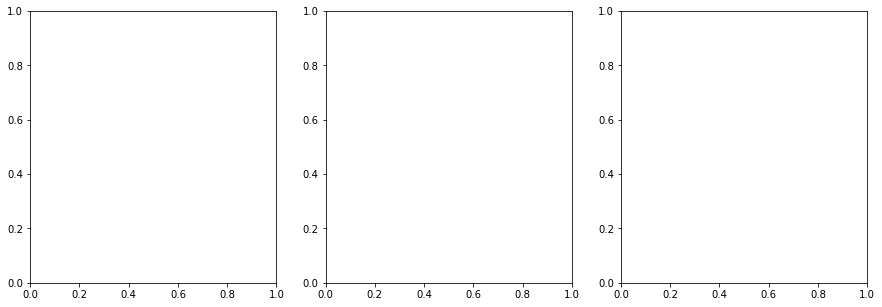

In [5]:
# MODEL COMPARISON
sigma=4
ds_data=xr.open_zarr('/scratch/zanna/data/cm2.6/coarse-surf-data-sigma-'+str(sigma)+'.zarr')
yy=ds_data.yu_ocean.values

runs=['G-'+str(i) for i in range(m)]
root='/scratch/cg3306/climate/runs/'
insize=[21,15,9,7,5,3]
outputtype=['Subgrid Momentum Forcing (u)',\
           'Subgrid Momentum Forcing (v)',\
           'Subgrid Temperature Forcing']
datatype=['Surface',\
           'Deep (110 m)']
modeltype=['LCNN','QCNN']
ncols=len(outputtype)
fig,axs=plt.subplots(1,ncols,figsize=(15,5))

xx=ds_zarr.yu_ocean.values
for j in range(ncols):
    ax=axs[j]
    
    
    for k in range(m):
        foldername=run[k]
        with np.errstate(divide='ignore'):
            MSE=np.load(root+foldername+'/MSE.npy')
            SC2=np.load(root+foldername+'/SC2.npy')

            R2=1-np.sum(MSE,axis=(0))/np.sum(SC2,axis=(0))
        mr2=np.zeros(R2.shape[0])
        sr2=mr2*1
        spread=(len(yy)-MSE.shape[1])//2
        mr2,sr2=longitude_average(R2)
        y=yy[spread:-spread]
        ax.plot(y,mr2,label='input-box = '+str(insize[k])+'x'+str(insize[k]))
        
        
        ax.set_ylabel('R2')
        ax.set_xlabel('latitude')
        ax.set_title(datype[j])
        ax.legend()
    ax.grid(color='k',linestyle='--',alpha=0.5)

In [ ]:
data_root='/scratch/zanna/data/cm2.6/coarse-'
raw_add=['3D-data-sigma-4-1.zarr','surf-data-sigma-4-1.zarr']
raw_co2=['1pct-CO2-'+ss for ss in raw_add]
raw_add=raw_add+raw_co2
raw_data_address=raw_add[int('0')%len(raw_add)]
ds_data=xr.open_zarr(data_root+raw_data_address)
yy=ds_data.yu_ocean.values
R2=[[] for i in range(4)]
for tt in range(4):
    raw_data_address=raw_add[int(tt)%len(raw_add)]
    
    MSELOC='/scratch/cg3306/climate/projection_analysis/'+raw_data_address+'MSE.npy'
    SC2LOC='/scratch/cg3306/climate/projection_analysis/'+raw_data_address+'SC2.npy'
    MSE=np.load(MSELOC)
    SC2=np.load(SC2LOC)
    r2=1-MSE/SC2
    r2=[longitude_average(rr) for rr in r2]
    R2[tt]=r2
names=['deep','surf','1%co2-deep','1%co2-surf']
titles=[s+'-subgrid forcing' for s in ['u','v','T']]
fig,axs=plt.subplots(1,3,figsize=(15,5))
for i in range(3):
    ax=axs[i]
    for j in range(4):
        ax.plot(yy,R2[j][i],label=names[j])
    ax.legend()
    ax.set_xlabel('latitude')
    ax.set_ylabel('average R2')
    ax.set_title(titles[i])

In [6]:
def affine_map_decay_plots():
    root='/scratch/cg3306/climate/runs/'
    ending='/grad-probe-data-0.npy'
    filenames=['0-0','11-2','10-1']
    label=['Su' ,'Su-deep','ST']
    postlabel=['u','v','T']
    colors=list(mcolors.TABLEAU_COLORS)
    si=0
    #fig,axss=plt.subplots(1,len(filenames),figsize=(15,4))
    fig,axs=plt.subplots(1,1,figsize=(10,5))

    for i in range(len(filenames)):
        #axs=axss[i]
        filename=root+filenames[i]+ending
        G=np.load(filename)
        G=np.transpose(G,axes=[0,2,3,1])
        G=np.reshape(G,[-1,G.shape[3]])
        G=G[:,2:]
        mG=np.sum(np.abs(G),axis=1)
        G=G[mG>0,:]
        G=np.sort(G,axis=0)
        G=G[::-1]
        m=G.shape[0]//4

        k=G.shape[1]//11
        for j in range(k):
            #if j!=1:#skipping v
            I=np.arange(j*11,(j+1)*11)
            g=G[m*2,I]
            A=np.amax(g)
            axs.fill_between(np.arange(11),G[m,I],G[m*3,I],alpha=0.03,color='blue')

            alpha=1.5

            lg=np.power(-np.log(g/A),1/alpha)
            x=np.arange(len(g)).reshape([-1,1])
            #x=np.concatenate([x*0+1,x],axis=1)
            w=np.linalg.solve(x.T@x,x.T@lg)
            p=np.exp(-(x@w)**alpha)*A
            hndrth=np.power(-np.log(5e-2),1/alpha)/w[0]
            axs.axvline(x=hndrth,linestyle='--',color=colors[si])
            #axs.semilogy(p,'--')#,label=label[i]+postlabel[j])
            axs.semilogy(g,colors[si],label=\
                         'd('+label[i]+')/d'+postlabel[j])
            axs.semilogy(g,'.',color=colors[si])
            si+=1
    axs.legend()
    axs.text(3.2,1e-8,'95% decay radius')
    axs.set_xlabel('pixel distance from center')
    axs.grid(color='k',linestyle='--',alpha=0.5)
    axs.set_ylabel('avg energy')
    axs.set_title('Local Affine Map Concentration of Energy Around The Center')

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/cg3306/climate/runs/0-0/grad-probe-data-0.npy'

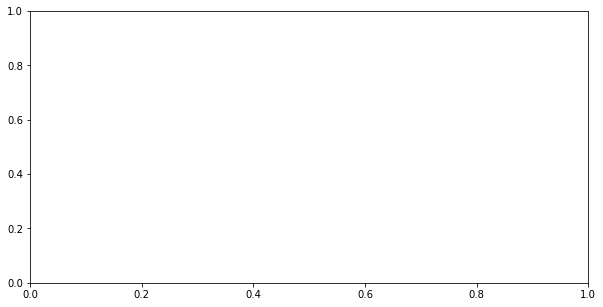

In [7]:
affine_map_decay_plots()

In [4]:
data_address='/scratch/zanna/data/cm2.6/coarse-3D-data-sigma-4.zarr/'
ds_zarr=xr.open_zarr(data_address)

In [5]:
x=ds_zarr.xu_ocean.values
y=ds_zarr.yu_ocean.values

In [18]:
ds_zarr

,Array,Chunk
Bytes,31.57 GiB,1.11 MiB
Shape,"(1460, 5, 645, 900)","(1, 2, 162, 450)"
Count,35041 Tasks,35040 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,31.57 GiB,1.11 MiB
Shape,"(1460, 5, 645, 900)","(1, 2, 162, 450)"
Count,35041 Tasks,35040 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [6]:
dx=x[1:]-x[:-1]
dy=y[1:]-y[:-1]


In [12]:
np.amin(dy)*30

5.068722525657705

In [15]:
np.sqrt((60/90)**2)*30

20.0

In [23]:
xmin=[-180,-110,-50,-48]
xmax=[-162,-92,-20,-30]
ymin=[35,-40,-20,0]
ymax=[50,-25,-5,15]

In [44]:
np.sqrt(510*1e6/111/111*2)

287.724674282366

In [53]:
rat=0
for i in range(4):
    dy=-ymin[i]+ymax[i]
    dx=-xmin[i]+xmax[i]
    xx=np.mean((xmin[i],xmax[i]))
    yy=np.mean((ymin[i],ymax[i]))*0
    A=111*dy*dx*np.cos(yy/180*np.pi)*111
    print("{:.1e}".format(A)+"  km2")
    rat+=A/(510*1e6)
print(rat)

3.3e+06  km2
3.3e+06  km2
5.5e+06  km2
3.3e+06  km2
0.030440117647058826


ValueError: x and y must have same first dimension, but have shapes (644,) and (1,)

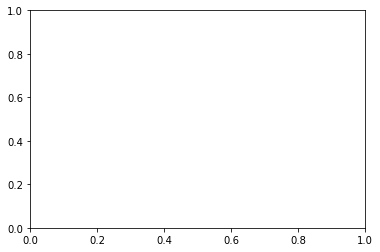

In [49]:
plt.plot(y[1:],dy)

In [13]:
raw_data_address='/scratch/zanna/data/cm2.6/coarse-surf-data-sigma-4-1.zarr'
u_v_dataset=xr.open_zarr(raw_data_address)

In [33]:
R2=uv.Su.values**2
mr2=np.zeros(R2.shape[0])
for i in range(R2.shape[0]):
    rr=R2[i]
    rr=rr[rr>0]
    rr[rr>1]=1
    with np.errstate(divide='ignore'):
        mr2[i]=np.mean(rr)

In [29]:
def longitude_average(R2):
    mr2=np.zeros(R2.shape[0])
    for i in range(R2.shape[0]):
        rr=R2[i]
        rr=rr[rr>0]
        rr[rr>1]=1
        with np.errstate(divide='ignore'):
            mr2[i]=np.mean(rr)
            
    return mr2

In [43]:
T=500
SE=np.zeros((6,u_v_dataset.ST.shape[1]))
names='ST ST1 Su Su1 Sv Sv1'.split()
for t in range(T):
    uv=u_v_dataset.isel(time=t)
    uv=uv[names]
    for j in range(len(names)):
        SE[j]+=longitude_average(uv[names[j]].values**2)/T
    if t%10==0:
        print(t)

/ext3/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/ext3/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


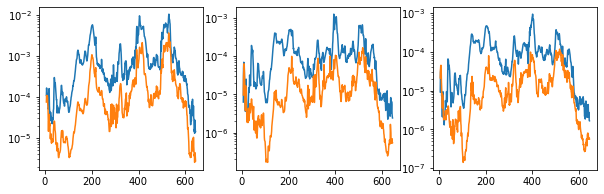

In [44]:
fig,axs=plt.subplots(1,3,figsize=(10,3))
for i in range(3):
    axs[i].semilogy(SE[i*2])
    axs[i].semilogy(SE[i*2+1])

In [4]:
raw_data_address='/scratch/zanna/data/cm2.6/3D-data.zarr'
#stratinds=np.array([0,10,20,30])
stratinds=np.array([0,10,15,20])
u_v_dataset=xr.open_zarr(raw_data_address)\
                .chunk(chunks={"time":1})\
                .isel(st_ocean=stratinds)\
                .drop("salt nv st_edges_ocean xt_ocean yt_ocean".split())\
                .rename({"u":"usurf","v":"vsurf","temp":"surface_temp"})
stratvals=np.concatenate([[0],u_v_dataset.st_ocean.values],axis=(0))
raw_data_address='/scratch/zanna/data/cm2.6/surf-data.zarr'
surf_dataset=xr.open_zarr(raw_data_address)\
                .chunk(chunks={"time":1})

In [5]:
root='/scratch/cg3306/climate/runs/'
foldername=runs[0][0]
MSE=np.load(root+foldername+'/MSE.npy')
SC2=np.load(root+foldername+'/SC2.npy')

R2=1-np.sum(MSE,axis=(0))/np.sum(SC2,axis=(0))


mr2=np.zeros(R2.shape[0])
spread=(len(xx)-MSE.shape[1])//2
for i in range(R2.shape[0]):
    rr=R2[i]
    rr=rr[rr>0]
    rr[rr>1]=1
    with np.errstate(divide='ignore'):
        mr2[i]=np.mean(rr)
x=xx[spread:-spread]

NameError: name 'runs' is not defined

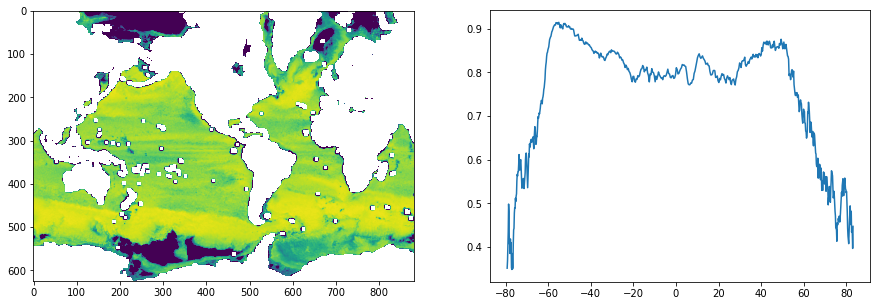

In [23]:


fig,axs=plt.subplots(1,2,figsize=(15,5))
axs[0].imshow(R2[::-1],vmin=0,vmax=1)
axs[1].plot(x,mr2)

/ext3/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/ext3/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/ext3/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/ext3/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/ext3/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/ext3/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  

ValueError: cannot reshape array of size 0 into shape (1,637,892)

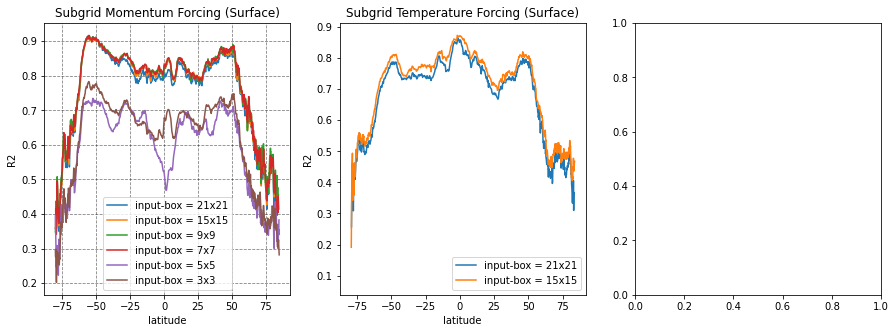

In [9]:
fig,axs=plt.subplots(1,3,figsize=(15,5))
runs=[[] for i in range(3)]
runs[0]=['9-'+str(i) for i in [1,2,3,4,5,6]]
runs[1]=['10-'+str(i) for i in [1,6,7,8,9,10]]
runs[2]=['11-'+str(i) for i in [2,21,22,23,24,25]]
insize=[21,15,9,7,5,3]
datype=['Subgrid Momentum Forcing (Surface)','Subgrid Temperature Forcing (Surface)','Subgrid Momentum Forcing (110m deep)']
xx=ds_zarr.yu_ocean.values
for j in [0,1,2]:
    ax=axs[j]
    run=runs[j]
    root='/scratch/cg3306/climate/runs/'
    
    for k in range(len(run)):
        foldername=run[k]
        with np.errstate(divide='ignore'):
            MSE=np.load(root+foldername+'/MSE.npy')
            SC2=np.load(root+foldername+'/SC2.npy')

            R2=1-np.sum(MSE,axis=(0))/np.sum(SC2,axis=(0))
        mr2=np.zeros(R2.shape[0])
        sr2=mr2*1
        spread=(len(xx)-MSE.shape[1])//2
        for i in range(R2.shape[0]):
            rr=R2[i]
            rr=rr[rr>0]
            rr[rr>1]=1
            with np.errstate(divide='ignore'):
                mr2[i]=np.mean(rr)
                sr2[i]=np.std(rr)
        x=xx[spread:-spread]
        ax.plot(x,mr2,label='input-box = '+str(insize[k])+'x'+str(insize[k]))
        
        
        ax.set_ylabel('R2')
        ax.set_xlabel('latitude')
        ax.set_title(datype[j])
        ax.legend()
    ax.grid(color='k',linestyle='--',alpha=0.5)

<ipython-input-7-20b54f3b9af6>:19: RuntimeWarning: invalid value encountered in true_divide
  R2=1-np.sum(MSE,axis=(0))/np.sum(SC2,axis=(0))
/ext3/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/ext3/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/ext3/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/ext3/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/ext3/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.

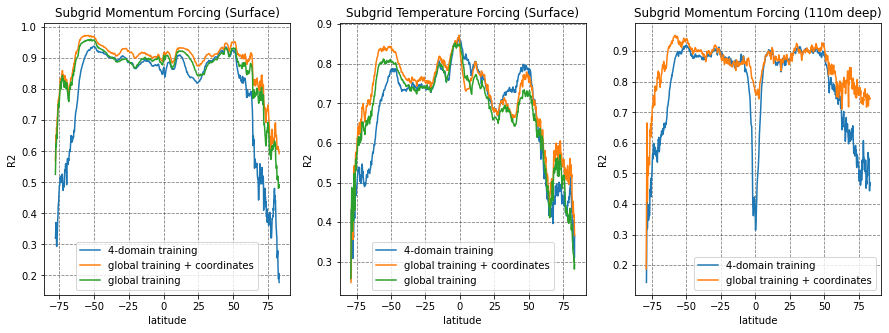

In [7]:
fig,axs=plt.subplots(1,3,figsize=(15,5))
runs[0]=['0-0','3-3','3-0']
runs[1]=['10-'+str(i) for i in [1,3,4]]
runs[2]=['11-'+str(i) for i in [2,12,17]]
leg=['4-domain training','global training + coordinates', 'global training']
datype=['Subgrid Momentum Forcing (Surface)','Subgrid Temperature Forcing (Surface)','Subgrid Momentum Forcing (110m deep)']
xx=ds_zarr.yu_ocean.values
for j in range(3):
    ax=axs[j]
    run=runs[j]
    root='/scratch/cg3306/climate/runs/'
    
    for k in range(len(run)):
        foldername=run[k]
        with np.errstate(divide='ignore'):
            MSE=np.load(root+foldername+'/MSE.npy')
            SC2=np.load(root+foldername+'/SC2.npy')

            R2=1-np.sum(MSE,axis=(0))/np.sum(SC2,axis=(0))
        mr2=np.zeros(R2.shape[0])
        sr2=mr2*1
        spread=(len(xx)-MSE.shape[1])//2
        for i in range(R2.shape[0]):
            rr=R2[i]
            rr=rr[rr>0]
            rr[rr>1]=1
            with np.errstate(divide='ignore'):
                mr2[i]=np.mean(rr)
                sr2[i]=np.std(rr)
        x=xx[spread:-spread]
        ax.plot(x,mr2,label=leg[k])
        
        
        ax.set_ylabel('R2')
        ax.set_xlabel('latitude')
        ax.set_title(datype[j])
        ax.legend()
    ax.grid(color='k',linestyle='--',alpha=0.5)

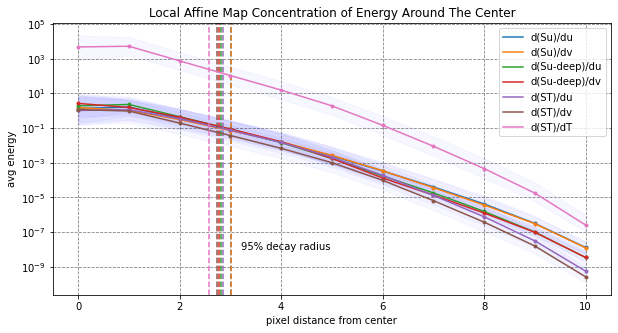

In [89]:
affine_map_decay_plots()

In [23]:
data_address=='/scratch/zanna/data/cm2.6/coarse-3D-data-sigma-4-1.zarr'
ds_zarr=xr.open_zarr(data_address)

In [24]:
ds_zarr

,Array,Chunk
Bytes,31.57 GiB,1.11 MiB
Shape,"(1460, 5, 645, 900)","(1, 2, 162, 450)"
Count,35041 Tasks,35040 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,31.57 GiB,1.11 MiB
Shape,"(1460, 5, 645, 900)","(1, 2, 162, 450)"
Count,35041 Tasks,35040 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [10]:
data_address=='/scratch/zanna/data/cm2.6/coarse-3D-data-sigma-4.zarr/'
ds_zarr=xr.open_zarr(data_address)
kinetic=ds_zarr.isel(time=np.arange(1)).usurf.values*0
forcing=[kinetic*0 for i in range(3)]
energy=[kinetic*0 for i in range(3)]
T=500
for i in range(T):
    t=i*10
    energy[0]+=ds_zarr.isel(time=np.arange(t,t+1)).usurf.values**2/T
    energy[1]+=ds_zarr.isel(time=np.arange(t,t+1)).vsurf.values**2/T
    energy[2]+=ds_zarr.isel(time=np.arange(t,t+1)).surface_temp.values**2/T
    forcing[0]+=ds_zarr.isel(time=np.arange(t,t+1)).Su.values**2/T
    forcing[1]+=ds_zarr.isel(time=np.arange(t,t+1)).Sv.values**2/T
    forcing[2]+=ds_zarr.isel(time=np.arange(t,t+1)).ST.values**2/T
    if i%50==0:
        print(i)

AttributeError: 'Dataset' object has no attribute 'surface_temp'

In [ ]:
relforcing=np.zeros((kinetic.shape[1],3))
for i in range(kinetic.shape[1]):
    kk=kinetic[0,i]
    kk=kk[kk==kk]
    for j in range(3):
        ff=forcing[j][0,i]
        ff=ff[ff==ff]
        relforcing[i,j]=np.mean(ff)/np.mean(kk)

Text(0, 0.5, 'relative energy')

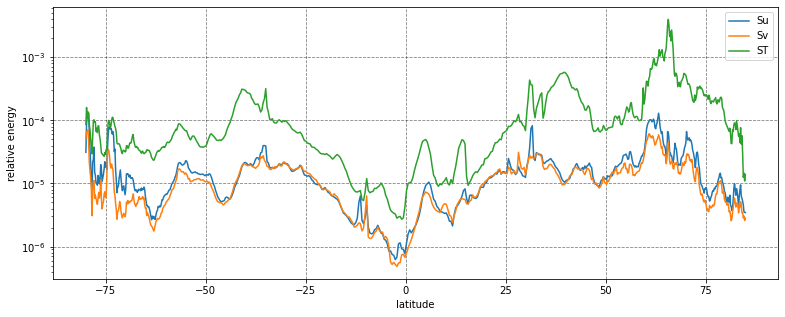

In [119]:
fig,axs=plt.subplots(1,1,figsize=(13,5))
lbl=['Su','Sv','ST']
for j in range(3):
    axs.semilogy(xx,relforcing[:,j],label=lbl[j])
axs.legend()
axs.grid(color='k',linestyle='--',alpha=0.5)
axs.set_xlabel('latitude')
axs.set_ylabel('relative energy')